# Guns & Smelling like ...

I wanted to take a look at the Jupyter Notebook. I also saw a graph [More Guns, More Gun Deaths by Mona Chalabi](https://www.instagram.com/p/BWk0pE-lKcH/?taken-by=mona_chalabi&hl=en).

The data in these calculations comes from the table [List of countries by firearm-related death rate](https://en.wikipedia.org/wiki/List_of_countries_by_firearm-related_death_rate) at Wikipedia.

In [52]:
import pandas as pd
import numpy as np
import re

def extract_year(text):
    m = re.search('(\d{4})', text)
    if m is None:
        return np.NaN
    else:
        return pd.to_numeric(m.group(0))

def best_year(row):
    if not np.isnan(row['Method of Calculation']):
        return row['Method of Calculation']
    else:
        return max([row['Homicides'], row['Suicides'], row['Unintentional'], row['Undetermined']])

page = 'https://en.wikipedia.org/wiki/List_of_countries_by_firearm-related_death_rate'
wiki_data = pd.read_html(page,header=0)
gun_toters = wiki_data[2]
gun_toters.drop(73, inplace=True)

gun_toters['Method of Calculation'] = gun_toters['Method of Calculation'].apply(extract_year)
gun_toters['Homicides'] = pd.to_numeric(gun_toters['Homicides'].apply(extract_year))
gun_toters['Suicides'] = gun_toters['Suicides'].apply(extract_year)
gun_toters['Unintentional'] = gun_toters['Unintentional'].apply(extract_year)
gun_toters['Undetermined'] = gun_toters['Undetermined'].apply(extract_year)
gun_toters['Country'] = gun_toters['Country'].apply(lambda s: s.split("!")[0].strip())
gun_toters['Deaths'] = pd.to_numeric(gun_toters['Total'])
gun_toters['Guns'] = pd.to_numeric(gun_toters['Guns per 100 hab'], errors='coerce')
gun_toters['Year'] = gun_toters.apply(best_year, axis=1)
gun_toters.drop(['Total',
                 'Guns per 100 hab',
                 'Method of Calculation',
                 'Homicides',
                 'Suicides',
                 'Unintentional',
                 'Undetermined',
                 'Sources and notes'], inplace=True,axis=1)
gun_toters.sort_values(by='Deaths', inplace=True)
gun_toters.dropna(inplace=True)
print ("Excerpt ...")
print (gun_toters[0:5])
pd.DataFrame([gun_toters['Deaths'].describe(), gun_toters['Guns'].describe()])

Excerpt ...
        Country  Deaths  Guns    Year
34        Japan    0.06   0.6  2008.0
60  South Korea    0.08   1.1  2011.0
54      Romania    0.14   0.7  2012.0
53        Qatar    0.15  19.2  2004.0
56    Singapore    0.16   0.5  2006.0


,count,mean,std,min,25%,50%,75%,max
Deaths,69.0,6.842029,12.839734,0.06,0.95,1.87,6.36,67.18
Guns,69.0,15.939855,16.984003,0.50,6.40,10.70,21.70,112.60


Now the data is sort of looking presentable. So we could do a quick graph.

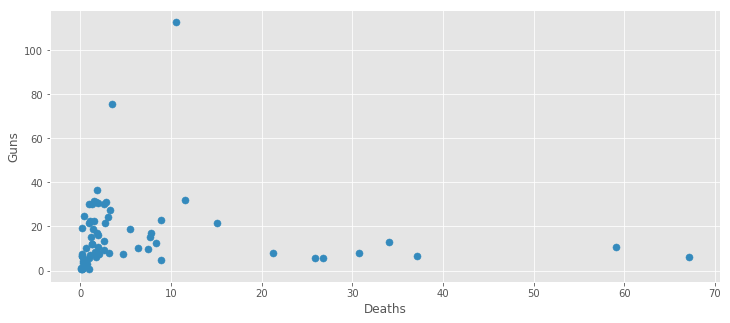

In [53]:
%matplotlib inline
import matplotlib.pyplot as plt
import matplotlib
plt.rcParams["figure.figsize"] = [12,5]

matplotlib.style.use('ggplot')
gun_toters_ax = gun_toters.plot.scatter(x='Deaths', y='Guns', s=50)
plt.show()

Not so brilliant ... But we do see sort of a pattern. Or three ...

## World bank data
Let's get some data from the [World bank](http://data.worldbank.org). They have all kinds of interesting information. To do that we need to get the countries by two letter codes first. So we can look at just the things we want.
This turned a bit messy. The library 'pycountry' was the best I could find, but people do love to write names in creative ways. So the first thing we need is a function to keep track of that kind of madness.
But once we are done the country code makes for a good index. Since countries appear only once.

In [54]:
import pycountry as pc
def country_code(country):
    country = country \
        .replace("Macedonia","Macedonia, Republic of") \
        .replace("South Korea","Korea, Republic of") \
        .replace("Korea, Rep.","Korea, Republic of") \
        .replace("Venezuela, RB","Venezuela")
    code = 'none found'
    try:
        code = pc.countries.get(name=country)
    except KeyError:
        try:
            code = pc.countries.get(common_name=country)
        except KeyError:
            try:
                code = pc.countries.get(official_name=country)
            except:
                print ("Whooopsie ...\n" + country)
    return code.alpha_2
gun_toters['C2'] = gun_toters['Country'].apply(lambda s: country_code(s))
gun_toters.set_index('C2', inplace=True)
print ("Excerpt ...")
print (gun_toters[0:5])

Excerpt ...
        Country  Deaths  Guns    Year
C2                                   
JP        Japan    0.06   0.6  2008.0
KR  South Korea    0.08   1.1  2011.0
RO      Romania    0.14   0.7  2012.0
QA        Qatar    0.15  19.2  2004.0
SG    Singapore    0.16   0.5  2006.0


Now we can get that juicy World bank data.

In [79]:
from pandas_datareader import wb
indicators=[
    'NY.GDP.PCAP.KD',    # GDP per capita
    'GB.XPD.RSDV.GD.ZS', # Research funding as percent GDP
    'SP.POP.SCIE.RD.P6', # No. researchers per million
    'EN.POP.SLUM.UR.ZS', # Percent population in slum
    'TX.VAL.TECH.MF.ZS'  # Percent of export that is High-tech
]

wb_values = wb.download(indicator=indicators, country=gun_toters.index)
wb_values.reset_index(inplace=True)
wb_values.columns = [
    'Country',
    'Year',
    'GDP',
    'Research',
    'Researchers',
    'Slums',
    'High-tech']
wb_values[0:5]

,Country,Year,GDP,Research,Researchers,Slums,High-tech
0,Argentina,2005,8522.522732,0.37867,814.091187,26.2,6.826630
1,Argentina,2004,7913.743124,0.36555,760.958679,NaN,7.719024
2,Argentina,2003,7337.792038,0.41012,714.366333,NaN,8.897495
3,Australia,2005,48702.734693,NaN,NaN,NaN,12.767628
4,Australia,2004,47817.899232,1.85394,4062.525391,NaN,13.533303


We don't really care to have the granularity of years though. So for each country we take the mean of the values. We also need the country code to match up with the other table. So let's make that an index here too. And we should drop the 'Country' column to avoid collisions with the other data set.

In [80]:
wb_values = \
    wb_values \
    .groupby(['Country']) \
    .mean() \
    .reset_index()
wb_values['C2'] = wb_values['Country'].apply(lambda s: country_code(s))
wb_values.drop(['Country'], axis=1, inplace=True)
wb_values.set_index('C2',inplace=True)
wb_values[0:5]

,GDP,Research,Researchers,Slums,High-tech
C2,,,,,
AR,7924.685965,0.384780,763.138733,26.2,7.814383
AU,47656.826371,1.853940,4062.525391,NaN,13.333150
AT,43754.735945,2.246533,3311.889038,NaN,15.146488
AZ,2488.282005,0.281070,NaN,NaN,2.794031
BB,15205.810863,NaN,NaN,NaN,17.303519


There seems to be quite a few NaNs there. Let's investigate ...

In [81]:
wb_values.isnull().sum()

GDP             0
Research       11
Researchers    20
Slums          49
High-tech       1
dtype: int64

So ... 'GDP' seems like a good variable to do some clustering on. And possibly 'High-tech'. The rest demands to much fudging. But we should drop the useless data and take a look at the missing value in 'High-tech'.

In [82]:
wb_values.drop(['Research', 'Researchers', 'Slums'], inplace=True,axis=1)
missing_value = wb_values[wb_values['High-tech'].isnull()]
missing_value

,GDP,High-tech
C2,,
ME,5215.925249,NaN


In [83]:
 pc.countries.get(alpha_2='ME')

Country(alpha_2='ME', alpha_3='MNE', name='Montenegro', numeric='499', official_name='Montenegro')

Ok ... Montenegro. Not a huge country in tech, from what I can tell. Lets find the countries in the same GDP range and assign something similar. Say the mean of that range.

I have no idea if it's reasonable, but plus minus 1000 in GDP would give a range to work with ...

In [84]:
min_gdp = missing_value.GDP[0] - 1000
max_gdp = missing_value.GDP[0] + 1000
ME_tech_range = wb_values[(wb_values.GDP > min_gdp) & (wb_values.GDP < max_gdp)]
ME_tech_range

,GDP,High-tech
C2,,
BG,5276.003003,4.422789
CO,5132.672316,5.766862
JM,4903.662668,0.086861
ME,5215.925249,NaN
PA,5810.007791,1.539080
RS,4353.453377,3.749469


In [85]:
mean_for_range = ME_tech_range['High-tech'].mean()
wb_values.set_value('ME', 'High-tech',mean_for_range)
wb_values[wb_values['High-tech'].isnull()]

,GDP,High-tech
C2,,


No nulls!

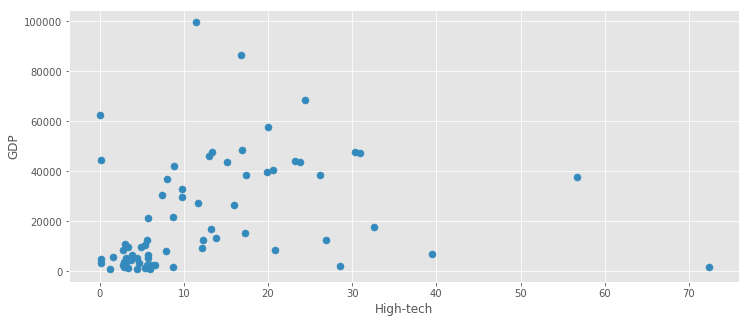

In [86]:
wb_values_ax = wb_values.plot.scatter(x='High-tech', y='GDP', s=50)
plt.show()

In [97]:
from sklearn.cluster import KMeans
kmeans = KMeans(n_clusters=3, random_state=0).fit(wb_values[['GDP', 'High-tech']])
wb_values['Cluster'] = kmeans.labels_
wb_values[0:5]

,GDP,High-tech,Cluster
C2,,,
AR,7924.685965,7.814383,1
AU,47656.826371,13.333150,0
AT,43754.735945,15.146488,0
AZ,2488.282005,2.794031,1
BB,15205.810863,17.303519,1


Not super helpful ... A colorised plot perhaps?

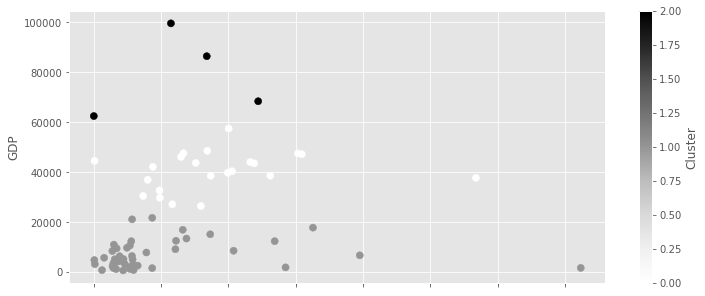

In [98]:
ax = wb_values.plot.scatter(
    x='High-tech',
    y='GDP',
    c='Cluster',
    s=50)
plt.show()

Now we would like to join up the two different datasets. This is why we've kept fighting to keep the 'C2' column in good shape.

In [99]:
gun_toters = gun_toters.join(wb_values)
gun_toters[0:5]

,Country,Deaths,Guns,Year,GDP,High-tech,Cluster
C2,,,,,,,
JP,Japan,0.06,0.6,2008.0,43603.112336,23.837842,0
KR,South Korea,0.08,1.1,2011.0,17870.083391,32.569983,1
RO,Romania,0.14,0.7,2012.0,6436.917463,3.845048,1
QA,Qatar,0.15,19.2,2004.0,62518.316634,0.009966,2
SG,Singapore,0.16,0.5,2006.0,37790.268392,56.770908,0


And then play a bit with the numbers.

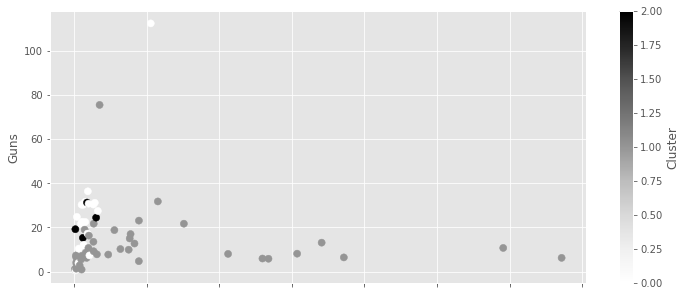

In [104]:
ax = gun_toters.plot.scatter(x='Deaths', y='Guns', c='Cluster', s=50)
plt.show()

Now we get to see the plot above with a socioeconomic overlay. Yey!

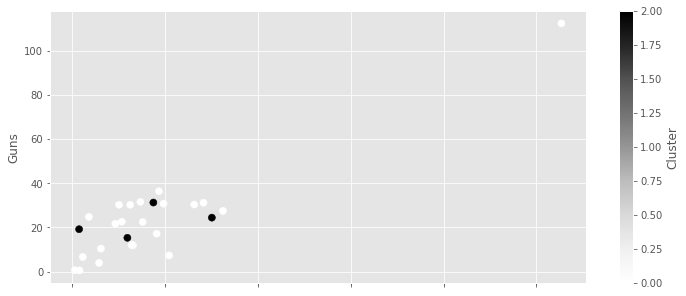

In [107]:
ax = gun_toters[gun_toters.Cluster != 1].plot.scatter(x='Deaths', y='Guns', c='Cluster', s=50)
plt.show()

For rich countries this seems very linear ...

In [128]:
from sklearn.linear_model import LinearRegression
lr = LinearRegression()

rich_toters = gun_toters[gun_toters.Cluster != 1]
X = rich_toters['Guns'].values
Y = rich_toters['Deaths'].values
X = X.reshape(len(X), 1)
Y= Y.reshape(len(Y), 1)
lr.fit(X,Y)

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=1, normalize=False)

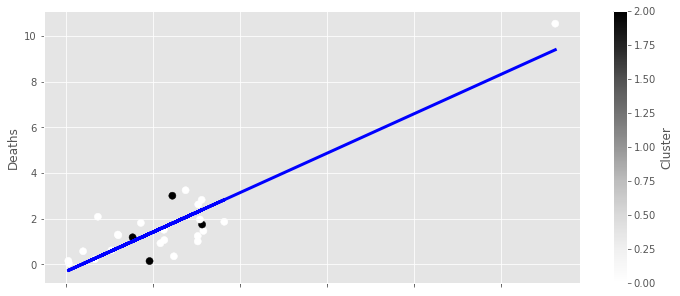

In [132]:
ax = rich_toters.plot.scatter(x='Guns', y='Deaths', c='Cluster', s=50)
plt.plot(X, lr.predict(X), color='blue', linewidth=3)
plt.show()

Seems ok?

In [137]:
gun_toters[gun_toters.Cluster == 2]

,Country,Deaths,Guns,Year,GDP,High-tech,Cluster
C2,,,,,,,
QA,Qatar,0.15,19.20,2004.0,62518.316634,0.009966,2
LU,Luxembourg,1.19,15.30,2011.0,99612.567971,11.463384,2
NO,Norway,1.75,31.30,2012.0,86465.847954,16.787543,2
CH,Switzerland,3.01,24.45,2015.0,68445.874561,24.425477,2


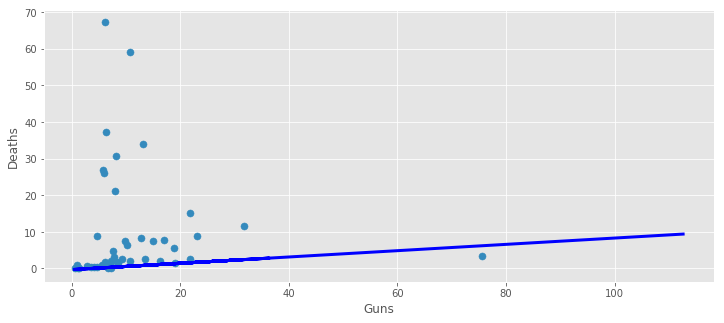

In [134]:
poor_toters = gun_toters[gun_toters.Cluster == 1]
ax = poor_toters.plot.scatter(x='Guns', y='Deaths', s=50)
plt.plot(X, lr.predict(X), color='blue', linewidth=3)
plt.show()


Here we sort of follow the same pattern for some of the points. Could be interesting to cluster this group. Or increase the number of clusters above.

In [138]:
poor_toters[poor_toters.Deaths > 50]

,Country,Deaths,Guns,Year,GDP,High-tech,Cluster
C2,,,,,,,
VE,Venezuela,59.13,10.7,2009.0,11077.990259,2.986381,1
HN,Honduras,67.18,6.2,2013.0,1736.859567,2.914155,1
